In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.metrics import log_loss, confusion_matrix, auc, precision_score, recall_score, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

# 1. Loading the dataset

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


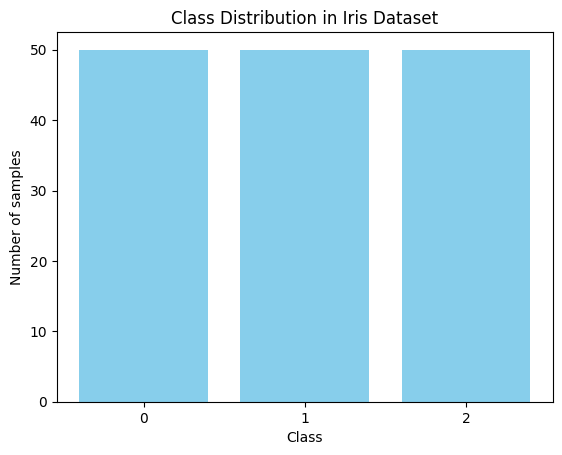

Class counts:
 target
0    50
1    50
2    50
Name: count, dtype: int64


In [ ]:
data = load_iris()
X = data.data
Y = data.target
df = pd.DataFrame(X, columns = data.feature_names)
df['target'] = Y
print(df.head())

# 2. Distribution of dataset

In [ ]:
class_counts = df['target'].value_counts().sort_index()
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution in Iris Dataset')
plt.xticks(class_counts.index)
plt.show()

# Check if balanced
print("Class counts:\n", class_counts)

# 3. Encoding the dataset as one-hot vectors

In [ ]:
encoder = OneHotEncoder(sparse_output=False) # one-hot encoder implementation
Y_encoded = encoder.fit_transform(Y.reshape(-1, 1)) # reshaping because OneHotEncoder expects the input to be 2D, not 1D.
Y_encoded_df = pd.DataFrame(Y_encoded, columns=encoder.get_feature_names_out(['target']))

print(Y_encoded_df)

     target_0  target_1  target_2
0         1.0       0.0       0.0
1         1.0       0.0       0.0
2         1.0       0.0       0.0
3         1.0       0.0       0.0
4         1.0       0.0       0.0
..        ...       ...       ...
145       0.0       0.0       1.0
146       0.0       0.0       1.0
147       0.0       0.0       1.0
148       0.0       0.0       1.0
149       0.0       0.0       1.0

[150 rows x 3 columns]


# 4. Splitting the data into training, validation and test sets

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid, Y_valid, test_size=0.5, random_state=42)

Y_train = Y_train.flatten()
Y_valid = Y_valid.flatten()
Y_test = Y_test.flatten()

# 5. Preprocessing the dataset

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# 6. Implementing Softmax Logistic Regression

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.W = None
        self.b = None # weights and biases will be initiazed later

    def softmax(self, z):

        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y, num_classes):
        one_hot = np.zeros((y.shape[0], num_classes))
        one_hot[np.arange(y.shape[0]), y] = 1
        return one_hot

    def fit(self, X, y):
        n_samples, n_features = X.shape
        num_classes = len(np.unique(y))

        # initialize weights and biases with zeros
        self.W = np.zeros((n_features, num_classes))
        self.b = np.zeros((1, num_classes))

        y_one_hot = self._one_hot(y, num_classes)

        for _ in range(self.n_iterations):

            scores = np.dot(X, self.W) + self.b
            probs = self.softmax(scores) # apply softmax

            grad_W = (1 / n_samples) * np.dot(X.T, (probs - y_one_hot))
            grad_b = (1 / n_samples) * np.sum(probs - y_one_hot, axis=0, keepdims=True)


            self.W -= self.learning_rate * grad_W
            self.b -= self.learning_rate * grad_b # update wights and bias

    def predict(self, X):
        scores = np.dot(X, self.W) + self.b
        probs = self.softmax(scores)
        return np.argmax(probs, axis=1) # return class with highest probability

    def predict_proba(self, X):
        scores = np.dot(X, self.W) + self.b
        return self.softmax(scores)

# 7. Using cross entropy as loss and apply L2 regularization weights in the cost function

In [ ]:
def compute_loss_with_L2(model, X, Y, lamb):
    probs = model.predict_proba(X)
    Y = Y.flatten().astype(int) # convert integer type for indexing
    one_hot_Y = np.eye(probs.shape[1])[Y] # eye to create identity matrix
    loss = log_loss(one_hot_Y, probs) # measures the performance of a classification model
    l2 = (lamb / 2) * np.sum(model.W**2)
    return loss + l2

def fit_L2(model, X_train, Y_train, X_val, Y_val, lamb) :
  n_samples =  X_train.shape[0]
  num_classes = len(np.unique(Y_train))
  # one-hot encode training
  y_one_hot = np.zeros((Y_train.shape[0], num_classes))
  y_one_hot[np.arange(Y_train.shape[0]), Y_train] = 1

  # one-hot encode validation
  y_val_one_hot = np.zeros((Y_val.shape[0], num_classes))
  y_val_one_hot[np.arange(Y_val.shape[0]), Y_val] = 1

  # Initialize model weights and bias to zeros
  model.W = np.zeros((X_train.shape[1], num_classes))
  model.b = np.zeros((1, num_classes))

  train_losses = []
  val_losses = []

  for _ in range(model.n_iterations) :
    scores = np.dot(X_train, model.W) + model.b # compute linear scores
    probs = np.exp(scores - np.max(scores, axis=1, keepdims=True)) # compute softmax probabilities
    probs /= np.sum(probs, axis=1, keepdims=True)

    grad_W = (1/n_samples) * np.dot(X_train.T, (probs - y_one_hot)) + lamb * model.W # set gradients with L2 regularization
    grad_b = (1/n_samples) * np.sum(probs - y_one_hot, axis=0, keepdims=True)

    model.W -= model.learning_rate * grad_W # Update weights and biases using gradient descent
    model.b -= model.learning_rate * grad_b

    train_loss = compute_loss_with_L2(model, X_train, Y_train, lamb) # Compute and record training and validation loss
    val_loss = compute_loss_with_L2(model, X_val, Y_val, lamb)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

  return train_losses, val_losses


def cross_validate_LR(X, Y, learning_rates, lambdas, k=5):
    best_score = float("inf") # Initialize best score as infinity
    best_params = None

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for rates in learning_rates:
        for n in lambdas:
            fold_loss = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                Y_train, Y_val = Y[train_index].flatten(), Y[val_index].flatten()

                model = LogisticRegression(learning_rate=rates, n_iterations=300)
                train_losses, val_losses = fit_L2(model, X_train, Y_train, X_val, Y_val, n)

                fold_loss.append(val_losses[-1])

            avg_loss = np.mean(fold_loss)
            print(f"LR={rates}, Lambda={n}, Avg Val Loss={avg_loss:.4f}")

            if avg_loss < best_score: # Update best score and parameters if current is better (lower loss)
                best_score = avg_loss
                best_params = (rates, n)

    return best_params


Applying learning rates and required lambda values.

LR=0.01, Lambda=0.1, Avg Val Loss=0.5733
LR=0.01, Lambda=0.01, Avg Val Loss=0.4938
LR=0.01, Lambda=0.001, Avg Val Loss=0.4844
LR=0.01, Lambda=0.0001, Avg Val Loss=0.4835
LR=0.005, Lambda=0.1, Avg Val Loss=0.6398
LR=0.005, Lambda=0.01, Avg Val Loss=0.5961
LR=0.005, Lambda=0.001, Avg Val Loss=0.5914
LR=0.005, Lambda=0.0001, Avg Val Loss=0.5909
LR=0.001, Lambda=0.1, Avg Val Loss=0.8974
LR=0.001, Lambda=0.01, Avg Val Loss=0.8923
LR=0.001, Lambda=0.001, Avg Val Loss=0.8918
LR=0.001, Lambda=0.0001, Avg Val Loss=0.8917
LR=0.0005, Lambda=0.1, Avg Val Loss=0.9833
LR=0.0005, Lambda=0.01, Avg Val Loss=0.9818
LR=0.0005, Lambda=0.001, Avg Val Loss=0.9816
LR=0.0005, Lambda=0.0001, Avg Val Loss=0.9816
LR=0.0001, Lambda=0.1, Avg Val Loss=1.0727
LR=0.0001, Lambda=0.01, Avg Val Loss=1.0727
LR=0.0001, Lambda=0.001, Avg Val Loss=1.0727
LR=0.0001, Lambda=0.0001, Avg Val Loss=1.0727
Best LR: 0.01, Best Lambda: 0.0001


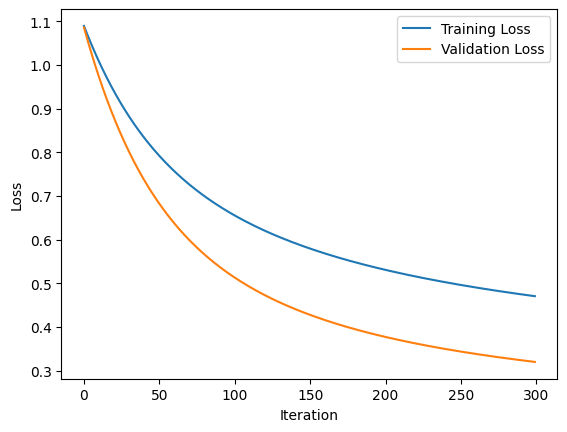

In [ ]:
learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
lambdas = [0.1, 0.01, 0.001, 0.0001] # values for lambdas and learning rates

best_lr, best_lambda = cross_validate_LR(X_train, Y_train, learning_rates, lambdas)
print(f"Best LR: {best_lr}, Best Lambda: {best_lambda}")

final_model = LogisticRegression(learning_rate=best_lr, n_iterations=300) # Set n_iterations to 300 for training
train_losses, val_losses = fit_L2(final_model, X_train, Y_train, X_valid, Y_valid, best_lambda)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 8. Prediction Performance

In [ ]:

model = LogisticRegression(learning_rate=0.01, n_iterations=1000)
model.fit(X_train, Y_train)


y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)


cm = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:\n", cm)


precision = precision_score(Y_test, y_pred, average="macro")
recall = recall_score(Y_test, y_pred, average="macro")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")


precision_vals = dict()
recall_vals = dict()
pr_auc_vals = dict()

# Loop through each class to compute precision-recall curves and AUC
for class_id in range(y_scores.shape[1]):
    precision_vals[class_id], recall_vals[class_id], _ = precision_recall_curve(
        (Y_test == class_id).astype(int), # Binary label: current class vs. rest
        y_scores[:, class_id]
    )
    pr_auc_vals[class_id] = auc(recall_vals[class_id], precision_vals[class_id])

print("AUPRC per class:")
for class_id, auc_val in pr_auc_vals.items():
    print(f"Class {class_id}: {auc_val:.4f}")

print(f"Mean AUPRC: {np.mean(list(pr_auc_vals.values())):.4f}")


Confusion Matrix:
 [[6 0 0]
 [0 5 5]
 [0 0 7]]
Precision (macro): 0.8611
Recall (macro): 0.8333
AUPRC per class:
Class 0: 1.0000
Class 1: 0.9290
Class 2: 0.9233
Mean AUPRC: 0.9508


# 9. Using Scikit Learn's Logistic Regression

In [ ]:
C_value = 1 / best_lambda


# Creatingh a multinomial logistic regression model with L2 regularization

sk_model = SklearnLogisticRegression(
    multi_class='multinomial',
    penalty='l2',
    C=C_value,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)


sk_model.fit(X_train, Y_train) # Train the scikit-learn logistic regression model


y_pred_sk = sk_model.predict(X_test)
y_scores_sk = sk_model.predict_proba(X_test)


cm_sk = confusion_matrix(Y_test, y_pred_sk)
print("Confusion Matrix (scikit-learn):\n", cm_sk)

precision_sk = precision_score(Y_test, y_pred_sk, average='macro')
recall_sk = recall_score(Y_test, y_pred_sk, average='macro')
print(f"Precision (macro) (scikit-learn): {precision_sk:.4f}")
print(f"Recall (macro) (scikit-learn): {recall_sk:.4f}")

# Dictionary to store AUPRC values for each class

pr_auc_sk = {}
for class_id in range(y_scores_sk.shape[1]):
    precision_vals, recall_vals, _ = precision_recall_curve(
        (Y_test == class_id).astype(int),
        y_scores_sk[:, class_id]
    )
    pr_auc_sk[class_id] = auc(recall_vals, precision_vals)

print("AUPRC per class (scikit-learn):")
for class_id, auc_val in pr_auc_sk.items():
    print(f"Class {class_id}: {auc_val:.4f}")

print(f"Mean AUPRC (scikit-learn): {np.mean(list(pr_auc_sk.values())):.4f}")


Confusion Matrix (scikit-learn):
 [[ 6  0  0]
 [ 0 10  0]
 [ 0  0  7]]
Precision (macro) (scikit-learn): 1.0000
Recall (macro) (scikit-learn): 1.0000
AUPRC per class (scikit-learn):
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000
Mean AUPRC (scikit-learn): 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# 10. Comparing the performance of both methods


In [ ]:
# Function to compute AUPRC (Area Under the Precision-Recall Curve) for each class separately

def compute_auprc_per_class(y_true, y_scores, num_classes):
    pr_auc = []
    for c in range(num_classes):
              # Compute area under the PR curve for this class
        precision, recall, _ = precision_recall_curve((y_true == c).astype(int), y_scores[:, c])
        pr_auc.append(auc(recall, precision))
    return pr_auc


y_pred_custom = final_model.predict(X_test)
y_scores_custom = final_model.predict_proba(X_test)

custom_accuracy = accuracy_score(Y_test, y_pred_custom)
custom_precision = precision_score(Y_test, y_pred_custom, average='macro')
recall_custom = recall_score(Y_test, y_pred_custom, average='macro')
auprc_custom = compute_auprc_per_class(Y_test, y_scores_custom, num_classes=y_scores_custom.shape[1])
mean_auprc_custom = sum(auprc_custom) / len(auprc_custom) # Average AUPRC across classes


y_pred_sk = sk_model.predict(X_test)
y_scores_sk = sk_model.predict_proba(X_test)

acc_sk = accuracy_score(Y_test, y_pred_sk)
prec_sk = precision_score(Y_test, y_pred_sk, average='macro')
recall_sk = recall_score(Y_test, y_pred_sk, average='macro')
auprc_sk = compute_auprc_per_class(Y_test, y_scores_sk, num_classes=y_scores_sk.shape[1])
mean_auprc_sk = sum(auprc_sk) / len(auprc_sk)

print("Custom Logistic Regression Performance:")
print(f"Accuracy: {custom_accuracy:.4f}")
print(f"Precision (macro): {custom_precision:.4f}")
print(f"Recall (macro): {recall_custom:.4f}")
print(f"Mean AUPRC: {mean_auprc_custom:.4f}\n")

print("Scikit-learn Logistic Regression Performance:")
print(f"Accuracy: {acc_sk:.4f}")
print(f"Precision (macro): {prec_sk:.4f}")
print(f"Recall (macro): {recall_sk:.4f}")
print(f"Mean AUPRC: {mean_auprc_sk:.4f}")


Custom Logistic Regression Performance:
Accuracy: 0.7391
Precision (macro): 0.8462
Recall (macro): 0.8000
Mean AUPRC: 0.9314

Scikit-learn Logistic Regression Performance:
Accuracy: 1.0000
Precision (macro): 1.0000
Recall (macro): 1.0000
Mean AUPRC: 1.0000
